# User-User content based filtering experiments
## By Carter Andrew
### 7/22/23
Reference: https://medium.com/grabngoinfo/recommendation-system-user-based-collaborative-filtering-a2e76e3e15c4

Summary: User-user content based filtering leads to very impressive results given very clean data, such as classes taken by students. It thrives at predicting by using cosign similarity to identify similar users and then predicts scores using the weighted average of their scores. We managed to achive a average reccomendation accuracy of upwards of $97.5\%$ across all predictions and a score prediction similarity of aproximately $50\%$

### Imports

In [1]:
import pandas as pd
import numpy as np
import scipy as sp

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics.pairwise import cosine_similarity

import sys

### Data

In [2]:
student_data = pd.read_excel("dataset/StudentInformationTable.xlsx")
course_data = pd.read_excel("dataset/CourseInformationTable.xlsx")
career_data = pd.read_excel("dataset/CourseSelectionTable.xlsx")

In [3]:
display(student_data.describe())
display(student_data.head(5))

,StudentId,EnrollmentYear
count,4568.000000,4568.000000
mean,2284.500000,2018.295972
std,1318.812344,1.191886
min,1.000000,2000.000000
25%,1142.750000,2018.000000
50%,2284.500000,2019.000000
75%,3426.250000,2019.000000
max,4568.000000,2020.000000


,StudentId,EnrollmentYear,Education,Major
0,1115,2018,Undergraduate,Biological Science
1,1108,2018,Undergraduate,Biological Science
2,1192,2018,Undergraduate,Urban and Rural Planning
3,1193,2018,Undergraduate,Urban and Rural Planning
4,1293,2018,Undergraduate,World History


In [4]:
display(course_data.describe())
display(course_data.head(5))

,CourseId,Grade
count,5591.000000,5225.000000
mean,2796.000000,2.436842
std,1614.127009,0.939362
min,1.000000,0.000000
25%,1398.500000,2.000000
50%,2796.000000,2.000000
75%,4193.500000,3.000000
max,5591.000000,12.000000


,CourseId,CourseName,College,Type,Grade,Prerequisite,Introduction
0,362,Fascinating Robot,College of Engineering,Whole school optional,2.0,NaN,This course is open to all students in the sch...
1,1045,Introduction to Seismology,School of Earth and Space Sciences,General elective course,2.0,NaN,This course is a quality education general cou...
2,1647,Speeches and oral cultures in China,Department of Chinese Language and Literature,Whole school optional,2.0,NaN,The course is based on the introduction and re...
3,1830,Modern Chinese History,Department of History,Required major,4.0,ancient Chinese history,This course is based on a large number of orig...
4,1834,Chinese Historiography,Department of History,optional,3.0,NaN,This course is a compulsory course for undergr...


In [5]:
display(career_data.describe())
display(career_data.head(5))

,StudentId,Semester,CourseId,Score
count,208949.000000,208941.000000,208949.000000,149223.000000
mean,1878.772590,1.505344,2578.111147,81.154792
std,1245.936537,0.532999,1732.925391,13.841620
min,1.000000,1.000000,1.000000,0.000000
25%,778.000000,1.000000,750.000000,78.000000
50%,1695.000000,1.000000,2569.000000,84.000000
75%,2914.000000,2.000000,4151.000000,90.000000
max,4568.000000,3.000000,5591.000000,100.000000


,StudentId,AcademicYear,Semester,CourseId,CourseName,CourseCollege,Score
0,1115,18-19,1.0,146,Advanced Mathematics (B) (1),National School of Development,81.0
1,1115,18-19,1.0,148,Problem-solving on Higher Mathematics (B),School of Economics,NaN
2,1115,18-19,1.0,654,General Chemistry Practice,College of Engineering,NaN
3,1115,18-19,1.0,681,General Chemistry (B),Department of Medicine Teaching office,72.0
4,1115,18-19,1.0,684,General Chemistry Lab.（B）,Department of Medicine Teaching office,83.5


Note: We think the missing grades are pass/fail classes but this is speculation

### Data cleaning/merging

In [6]:
career_data_clean = career_data.dropna()

In [7]:
print("Number of students in data:  ", career_data_clean.StudentId.nunique())
print("Range of scores:             ", career_data_clean.Score.min(), career_data_clean.Score.max())
print("Unique scores in dataset:    ")
print(np.array(sorted(career_data_clean.Score.unique())))

Number of students in data:   4546
Range of scores:              0.0 100.0
Unique scores in dataset:    
[  0.    1.    1.5   2.    2.5   3.    3.5   4.    5.    5.5   6.    7.
   7.5   8.    9.    9.5  10.   11.   12.   12.5  13.   14.   14.5  15.
  16.   16.5  17.   18.   19.   19.5  20.   20.5  21.   22.   22.5  23.
  23.5  23.6  24.   25.   25.5  26.   27.   27.5  28.   28.5  29.   30.
  30.5  31.   32.   33.   34.   34.5  35.   35.5  36.   36.5  37.   37.5
  38.   38.5  39.   39.5  40.   40.5  41.   41.5  42.   42.5  43.   43.5
  44.   44.5  45.   45.5  46.   46.5  47.   47.5  48.   48.5  49.   49.5
  50.   50.5  51.   51.5  52.   52.5  53.   53.5  54.   54.5  55.   55.5
  56.   56.5  57.   57.5  58.   59.   59.5  60.   60.5  61.   61.5  62.
  62.5  63.   63.5  64.   64.5  65.   65.5  66.   66.5  66.6  67.   67.5
  68.   68.5  69.   69.5  70.   70.5  70.7  71.   71.5  72.   72.5  73.
  73.5  74.   74.5  75.   75.5  76.   76.5  77.   77.5  78.   78.5  79.
  79.5  80.   80.5  80.8  

In [8]:
career_student_data = pd.merge(career_data_clean, student_data, 'inner', 'StudentId')

In [9]:
display(career_student_data.describe())
display(career_student_data.head(5))

,StudentId,Semester,CourseId,Score,EnrollmentYear
count,149021.000000,149021.000000,149021.000000,149021.000000,149021.000000
mean,1631.926044,1.430362,2723.731306,81.136139,2017.849874
std,1163.655105,0.527811,1690.240923,13.840801,1.213044
min,1.000000,1.000000,2.000000,0.000000,2000.000000
25%,617.000000,1.000000,1103.000000,78.000000,2017.000000
50%,1411.000000,1.000000,2740.000000,84.000000,2018.000000
75%,2592.000000,2.000000,4152.000000,90.000000,2019.000000
max,4568.000000,3.000000,5591.000000,100.000000,2020.000000


,StudentId,AcademicYear,Semester,CourseId,CourseName,CourseCollege,Score,EnrollmentYear,Education,Major
0,1115,18-19,1.0,146,Advanced Mathematics (B) (1),National School of Development,81.0,2018,Undergraduate,Biological Science
1,1115,18-19,1.0,681,General Chemistry (B),Department of Medicine Teaching office,72.0,2018,Undergraduate,Biological Science
2,1115,18-19,1.0,684,General Chemistry Lab.（B）,Department of Medicine Teaching office,83.5,2018,Undergraduate,Biological Science
3,1115,18-19,1.0,748,Physiology,College of Life Sciences,85.0,2018,Undergraduate,Biological Science
4,1115,18-19,1.0,844,Physiology Lab.,College of Life Sciences,75.0,2018,Undergraduate,Biological Science


#### Number of classes taken! An important metric
Some students fail out of college, or have only just begun. These datapoints are not very useful for training or reccomending, because there are simply not that many datapoints to reccomend on. Because of this it will probably be useful to only train and reccomend on long lasting student carreers

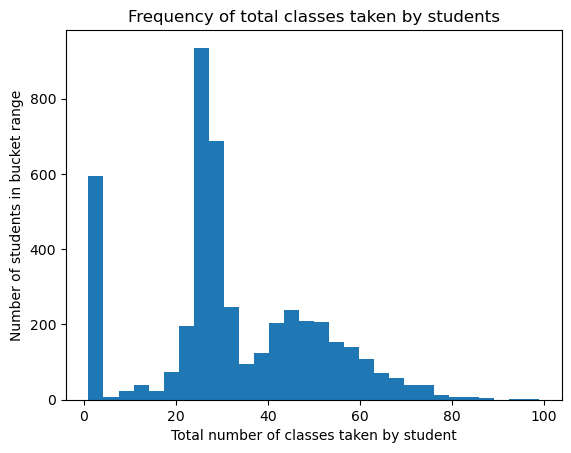

In [10]:
temp_matrix_def_not_jumping_ahead = career_student_data.pivot_table(index="StudentId", columns="CourseId", values="Score")
plt.hist(temp_matrix_def_not_jumping_ahead.count(axis=1), bins=30)
plt.title("Frequency of total classes taken by students")
plt.xlabel("Total number of classes taken by student")
plt.ylabel("Number of students in bucket range")
del(temp_matrix_def_not_jumping_ahead)

As we can see there is a ton of students who take 0-25 classes and call it quits. This is an indicator of a timestamp where students are graduating from programs, anything that extends beyond this is continued education. We can see another cutoff around the 45-50 mark, this might be for a masters program.

### Data partitioning
We should partition data on students, not on individual classes they have taken, so instead of partitioning by selecting random rows we will be selecting random students

In [11]:
all_student_ids = career_student_data.StudentId.unique()
training_students = np.random.choice(all_student_ids, int(all_student_ids.size * .8), False)
testing_students = np.array([i for i in all_student_ids if i not in training_students])
training_data = career_student_data[career_student_data["StudentId"].isin(training_students)]
testing_data = career_student_data[career_student_data["StudentId"].isin(testing_students)]
print("Number of total students:    ", all_student_ids.size)
print("Number of training students: ", training_students.size)
print("Number of testing students:  ", testing_students.size)
display(training_data.describe())
display(testing_data.describe())

Number of total students:     4546
Number of training students:  3636
Number of testing students:   910


,StudentId,Semester,CourseId,Score,EnrollmentYear
count,118828.000000,118828.000000,118828.000000,118828.000000,118828.000000
mean,1632.572500,1.429873,2721.448615,81.076576,2017.851668
std,1163.668904,0.527598,1693.424954,13.849080,1.221845
min,2.000000,1.000000,2.000000,0.000000,2000.000000
25%,619.000000,1.000000,1100.000000,78.000000,2017.000000
50%,1414.000000,1.000000,2737.000000,84.000000,2018.000000
75%,2589.000000,2.000000,4152.000000,90.000000,2019.000000
max,4568.000000,3.000000,5591.000000,100.000000,2020.000000


,StudentId,Semester,CourseId,Score,EnrollmentYear
count,30193.000000,30193.000000,30193.000000,30193.000000,30193.000000
mean,1629.381843,1.432286,2732.715100,81.370556,2017.842811
std,1163.616577,0.528651,1677.648834,13.805903,1.177761
min,1.000000,1.000000,2.000000,0.000000,2013.000000
25%,609.000000,1.000000,1189.000000,78.000000,2017.000000
50%,1391.000000,1.000000,2762.000000,84.000000,2018.000000
75%,2626.000000,2.000000,4152.000000,90.000000,2019.000000
max,4557.000000,3.000000,5591.000000,100.000000,2020.000000


Our means and standard deviations are looking pretty comparable, we could do a t-test to affirm the null hypothesis that our training and testing are 99% probably not statistically different. But I will do this later

### Student-Course Matrix

In [12]:
print("Our training matrix will be a", training_data.StudentId.nunique(), "by", training_data.CourseId.nunique(), "table")
print("Assuming we store a float at each point for the score our table will occupy:", training_data.StudentId.nunique() * training_data.CourseId.nunique() * sys.getsizeof(training_data.Score.iloc[0]) /1000000000, "GB")

Our training matrix will be a 3636 by 3460 table
Assuming we store a float at each point for the score our table will occupy: 0.40257792 GB


This is feasable to hold in memory, but definitely a huge table!

In [13]:
training_matrix = training_data.pivot_table(index="StudentId", columns="CourseId", values="Score")
print('Sample courses taken by the first student in our matrix, because the matrix is incredibly sparse\n', training_matrix.iloc[0].dropna())
display(training_matrix.head(5))

Sample courses taken by the first student in our matrix, because the matrix is incredibly sparse
 CourseId
146     60.000000
147     36.333333
167     36.000000
362     75.000000
992     86.000000
1045    80.000000
1393    84.000000
1919    83.000000
2622    80.000000
2630    64.500000
2632    48.000000
2651    60.000000
2652    64.000000
2657    57.000000
2660    60.000000
2663    85.000000
2664    81.000000
2667    54.000000
2669    77.000000
2676    82.000000
2681    77.000000
2686    71.000000
2687    54.500000
2688    86.000000
2689    60.000000
2690    77.000000
2694    75.000000
2695    86.000000
2696    76.000000
2697    71.000000
2701    75.000000
2702    80.000000
2717    85.000000
2720    74.000000
2724    78.000000
2730    62.000000
2731    80.000000
2741    60.000000
2742    76.000000
2745    65.000000
2827    86.000000
3796    81.000000
3809    66.000000
3810    60.000000
3811    60.000000
3812    78.000000
4151    84.000000
4156    82.000000
4157    76.000000
4158    93.

CourseId,2,6,7,9,10,15,20,21,27,28,...,5579,5580,5581,5582,5584,5587,5588,5589,5590,5591
StudentId,,,,,,,,,,,,,,,,,,,,,
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### GPA Time:
### __Note!!!__ We never ended up normalizing our data, this actually ended up decreasing our accuracy so it has been omitted
Because some students get a higher score than others we need to account for a students GPA so that are final scores are not biased by higher scoring students. To do this we will be normalizing our data by subtracting by the gpa and scaling variance to be on a scale between -1 and 1

In [14]:
train_mat_norm = training_matrix.subtract(training_matrix.mean(axis=1), axis=0)
df_mat_norm = train_mat_norm.divide(train_mat_norm.max(axis=1) * 2, axis=0)
train_mat_norm = train_mat_norm.add(.5)
print('Sample courses taken by the first student in our matrix, because the matrix is incredibly sparse\n', train_mat_norm.iloc[0].dropna())

Sample courses taken by the first student in our matrix, because the matrix is incredibly sparse
 CourseId
146    -11.506173
147    -35.172840
167    -35.506173
362      3.493827
992     14.493827
1045     8.493827
1393    12.493827
1919    11.493827
2622     8.493827
2630    -7.006173
2632   -23.506173
2651   -11.506173
2652    -7.506173
2657   -14.506173
2660   -11.506173
2663    13.493827
2664     9.493827
2667   -17.506173
2669     5.493827
2676    10.493827
2681     5.493827
2686    -0.506173
2687   -17.006173
2688    14.493827
2689   -11.506173
2690     5.493827
2694     3.493827
2695    14.493827
2696     4.493827
2697    -0.506173
2701     3.493827
2702     8.493827
2717    13.493827
2720     2.493827
2724     6.493827
2730    -9.506173
2731     8.493827
2741   -11.506173
2742     4.493827
2745    -6.506173
2827    14.493827
3796     9.493827
3809    -5.506173
3810   -11.506173
3811   -11.506173
3812     6.493827
4151    12.493827
4156    10.493827
4157     4.493827
4158    21.

#### Similarity metrics:
We will be using cosine similarity to get a mearsure of how similar users are

In [15]:
student_similarity = pd.DataFrame(cosine_similarity(train_mat_norm.fillna(0)), index=train_mat_norm.index, columns=train_mat_norm.index)
display(student_similarity.head(5))

StudentId,2,3,4,5,6,9,10,11,12,13,...,4555,4556,4558,4559,4560,4564,4565,4566,4567,4568
StudentId,,,,,,,,,,,,,,,,,,,,,
2,1.000000,0.032111,0.099871,0.165881,0.212985,0.167251,0.013802,0.079024,0.327907,0.379292,...,0.0,0.0,0.0,0.0,0.0,0.229667,-0.037091,0.242747,0.152823,0.210887
3,0.032111,1.000000,0.014461,0.033143,0.069237,0.006518,0.010902,0.009505,0.050677,0.089484,...,0.0,0.0,0.0,0.0,0.0,0.040371,-0.022707,0.037166,0.012732,0.000947
4,0.099871,0.014461,1.000000,0.082593,0.116415,0.089257,0.000000,-0.000703,0.074979,0.132859,...,0.0,0.0,0.0,0.0,0.0,0.155067,0.050008,0.163254,0.081586,0.138159
5,0.165881,0.033143,0.082593,1.000000,0.047073,0.075224,0.020643,0.020708,0.183708,0.169263,...,0.0,0.0,0.0,0.0,0.0,0.115399,-0.044384,0.120937,0.080017,0.099175
6,0.212985,0.069237,0.116415,0.047073,1.000000,0.114030,0.000000,0.000117,0.099347,0.201010,...,0.0,0.0,0.0,0.0,0.0,0.108987,0.103634,0.127806,0.083089,0.182840


In [16]:
print('Median user similarity:', student_similarity.median().mean())

Median user similarity: 0.05373038580699857


## Recomendation System
Now that this system is working nicely we can write a couple of functions to calculate our reccomendation, and test our accuracy

First things first, we have a ton of data frames in memory we have no use for, so lets delete them

In [17]:
del_df = [student_data, student_similarity, career_data, career_data_clean, career_student_data, student_similarity, training_matrix]
for df in del_df:
    del(df)

### Testing Functions
Now we need a series of functions that will help us grab a test users, append controlled subsets of their classes, and append those to our data type list. Finally we can check our results by comparing our values to the rest of our data. 

I was considering trying to make the subset of courses selected for the tests to be random, but I don't really think that makes much sense given that there is no real course level number assosiated in the database

In [18]:
# This is a class made to reccomend classes using user-user content based reccomendation for specifically the files in this assignment
# Because we use certain labels to acess data like 'StudentId' this is not a general reccomender
# This can be initialized by inputting a dataframe where each row represents a class a student took, and assosiates the students id with the course id for that respective row
class userUserReccomender:
    # Stored values we compute, useful for cacheing values we will use commonly and stops us from recomputing or updating data frames excessively
    input_data: pd.DataFrame
    training_data: pd.DataFrame
    testing_data: pd.DataFrame
    student_course_matrix: pd.DataFrame
    # A boolean we use to indicate if we need to recompute the user-course matrix used for our reccomendation options. This matrix is large, almost half a gigabyte so it
    # is important we only update it when we need to
    matrix_current: bool
    # This is used to partition the data off into training and testing data. We tend not to use this function because it it makes more sense to simply omit certain classes from the
    # Students we want to train on instead of keeping everything seperate
    # This selecteds a proportion of students, provided by arguments to set into a training data set and puts the other students into a testing set
    # Keep in mind this partitions on students, not individual courses so we don't end up with incomplete student carreers in both sets
    def partitionData(self, proportion_training: float) -> None:
        all_student_ids = self.input_data.StudentId.unique()
        training_students = np.random.choice(all_student_ids, int(all_student_ids.size * proportion_training), False)
        testing_students = np.array([i for i in all_student_ids if i not in training_students])
        self.training_data = self.input_data[self.input_data["StudentId"].isin(training_students)]
        self.testing_data = self.input_data[self.input_data["StudentId"].isin(testing_students)]
        self.matrix_current = False
    # Used to undo a partition, by default all values are stored in the input data and this additionally stores them in our testing data
    # This is because our testing data is what is mainly used to compute our matrix
    def dePartitionData(self) -> None:
        self.training_data = self.input_data
        self.testing_data = pd.DataFrame()
        self.matrix_current = False
    # This is called on our input matrix, we first drop all students with all nan values for course score
    # Next we drop all students that have taken under 22 courses, these are people who have either dropped out or are not completed their degrees,
    # this means that the students will not be good to reccomend on because they will only reccomend a small subset of classes
    def preProcessData(self) -> None:
        #We only want data with large enough class counts to support a nuanced reccomendation. 
        self.dePartitionData()
        self.updateMatrix()
        dropIds = self.student_course_matrix[self.student_course_matrix.count(axis=1) < 22].index
        self.input_data = self.input_data.drop(self.input_data[self.input_data.StudentId.isin(dropIds)].index)
        self.dePartitionData()
        self.updateMatrix()
    # The init function takes in a daframe where courses taken by a particular student are rows, we need scores included for our system to work
    def __init__(self, input_data: pd.DataFrame) -> None:
        self.input_data = input_data
        self.preProcessData()
        self.matrix_current = True
    # This recomuputes our user-course matrix, you can do this externally but there are checks to prevent outdated matricies from being used internally
    def updateMatrix(self) -> None:
        self.student_course_matrix = self.training_data.pivot_table(index='StudentId', columns='CourseId', values='Score')
        self.matrix_current = True
    # Calculates reccomended courses for a single user, it outputs three values:
        # The fist value is the input courses, these are a subset of the courses the user we are predicting on took during their carreer
        # The second is the other courses the student took, that we did not use to predict on, we seperate these because our algorithm does not predict on courses we have allready taken, so we have the output courses seperate as what we compare against to evaluate accuracy
        # The third is the predictions we have made, we want these to match as closely as possible to our output courses, and not include any courses from our input courses
    def calculateSingleReccomendation(self, student_id: int, proportion_classes_taken: float, num_simlar_students: int) -> tuple[pd.Series, pd.Series, pd.Series]:
        if not self.matrix_current: self.updateMatrix()
        # Make and store sample carreers for output and updating our matrix
        full_carreer = self.student_course_matrix.loc[student_id].copy(deep=True)
        drop_courses = full_carreer.dropna().sample(int(full_carreer.count() * (1-proportion_classes_taken)))
        sample_carreer = full_carreer.copy(deep=True)
        sample_carreer.loc[drop_courses.index.tolist()] = np.nan
        #We update our matrix so the user selected appears to have only taken the sample carreer courses
        temp_matrix = self.student_course_matrix.copy(deep=True)
        temp_matrix.loc[student_id] = sample_carreer # type: ignore
        #Normalize data by subtracting the gpa
        #temp_matrix = temp_matrix.subtract(temp_matrix.mean(axis=1), axis=0)
        #sample_carreer = sample_carreer.subtract(full_carreer.mean())
        #drop_courses = drop_courses.subtract(full_carreer.mean())
        # Identify similar users by using cosine similarity across our matrix, but only compare on the courses our sample student has taken
        # We do this because if a student has taken many more courses than our sample student their similarity will be lower. So by only comparing to user taken courses we eliminate this issue
        similar_students = pd.DataFrame(cosine_similarity(temp_matrix[sample_carreer.dropna().index].fillna(0)), index=temp_matrix.index, columns=temp_matrix.index).drop(student_id)[student_id].sort_values(ascending=False)[:num_simlar_students]
        taken_courses = temp_matrix[temp_matrix.index == student_id].dropna(axis=1, how='all')
        reccomended_courses = temp_matrix[temp_matrix.index.isin(similar_students.index)].dropna(axis=1, how='all')
        # We drop courses we have allready taken from the reccomendations because reccomending courses we have allready taken makes no sense
        reccomended_courses.drop(taken_courses.columns,axis=1, inplace=True, errors='ignore')
        reccomendations = {}
        #Run through all our possible reccomended scores and predict a score as the weighted average of similar users scores based off similarity
        for course in reccomended_courses.columns:
            course_scores = reccomended_courses[course]
            course_score, course_count = 0,0
            for student in similar_students.index:
                if pd.isna(course_scores[student]): continue
                course_score += course_scores[student] * similar_students[student]
                course_count += similar_students[student]
            reccomendations[course] = course_score/course_count
        reccomendations = pd.Series(reccomendations, index=reccomendations.keys()).sort_values(ascending=False) # type: ignore
        return(sample_carreer, drop_courses, reccomendations)
    # Calculates reccomended courses for a single student provided via input of a series, the series index must include all courses or this will crash, it outputs three values:
        # The fist value is the input courses, these are a subset of the courses the user we are predicting on took during their carreer
        # The second is the other courses the student took, that we did not use to predict on, we seperate these because our algorithm does not predict on courses we have allready taken, so we have the output courses seperate as what we compare against to evaluate accuracy
        # The third is the predictions we have made, we want these to match as closely as possible to our output courses, and not include any courses from our input courses
    def calculateReccomendation(self, courses: pd.Series, student_id: int, num_similar_students: int) -> pd.Series:
        if not self.matrix_current: self.updateMatrix()
        temp_matrix = self.student_course_matrix.copy(deep=True)
        temp_matrix.drop(student_id, inplace=True)
        temp_matrix.loc[student_id] = courses # type: ignore
        #Normalize data by subtracting the gpa
        #temp_matrix = temp_matrix.subtract(temp_matrix.mean(axis=1), axis=0)
        #sample_carreer = sample_carreer.subtract(full_carreer.mean())
        #drop_courses = drop_courses.subtract(full_carreer.mean())
        # Identify similar users by using cosine similarity across our matrix, but only compare on the courses our sample student has taken
        # We do this because if a student has taken many more courses than our sample student their similarity will be lower. So by only comparing to user taken courses we eliminate this issue
        similar_students = pd.DataFrame(cosine_similarity(temp_matrix[courses.dropna().index].fillna(0)), index=temp_matrix.index, columns=temp_matrix.index).drop(student_id)[student_id].sort_values(ascending=False)[:num_similar_students]
        taken_courses = temp_matrix[temp_matrix.index == student_id].dropna(axis=1, how='all')
        reccomended_courses = temp_matrix[temp_matrix.index.isin(similar_students.index)].dropna(axis=1, how='all')
        # We drop courses we have allready taken from the reccomendations because reccomending courses we have allready taken makes no sense
        reccomended_courses.drop(taken_courses.columns,axis=1, inplace=True, errors='ignore')
        reccomendations = {}
        #Run through all our possible reccomended scores and predict a score as the weighted average of similar users scores based off similarity
        for course in reccomended_courses.columns:
            course_scores = reccomended_courses[course]
            course_score, course_count = 0,0
            for student in similar_students.index:
                if pd.isna(course_scores[student]): continue
                course_score += course_scores[student] * similar_students[student]
                course_count += similar_students[student]
            reccomendations[course] = course_score/course_count
        reccomendations = pd.Series(reccomendations, index=reccomendations.keys()).sort_values(ascending=False) # type: ignore
        return reccomendations
    # Same as above but with multiple students, this means we output 2d dataframes where every row represents the following, respectively per dataframe
        # The subset of student classes for that student we are reccomending on
        # The subset of student classes that were not used to generate reccomendations, these are what we compare againt for accuracy
        # The reccomendations for the given student, these will be compared againt output 2 for accuracy
    def calculateMultipleReccomendations(self, student_ids: list[int], proportion_classes_taken: float, num_similar_students: int) -> tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
        # Update matrix if needed
        if not self.matrix_current: self.updateMatrix()
        #Grab students we want to reccomend on, and generate a list of courses we are dropping from their carrers and the result sample carreer after the drop
        full_carreers = self.student_course_matrix.loc[student_ids]
        sample_carreers = full_carreers.copy(deep=True)
        #We never use full carreers again so we can do a shallow copy
        drop_courses = full_carreers.copy()
        for i, student in full_carreers.iterrows():
            drop_course = (student.dropna().sample(int(student.dropna().count() * (1-proportion_classes_taken))))
            drop_courses.loc[i, ~drop_courses.columns.isin(drop_course.index)] = np.nan # type: ignore
            sample_carreers.loc[i,drop_course.index] = np.nan # type: ignore
        #The temp matrix is used to store our student-course matrix but with our selected students sample carreers
        temp_matrix = self.student_course_matrix.copy(deep=True)
        temp_matrix.loc[sample_carreers.index.tolist()] = sample_carreers
        #Make a dataframe to load our final reccomendations into
        reccomendations = pd.DataFrame(index=student_ids, columns=temp_matrix.columns)
        #Loop over each selected student and fill the respective row in our reccomendation dataframe
        for student_id in student_ids:
            #Calculate cosign similarity for all students on only courses the selected student has taken, see single reccomdation for reasoning
            student_similarity = pd.DataFrame(cosine_similarity(temp_matrix[sample_carreers.loc[student_id].dropna().index].fillna(0)), index=temp_matrix.index, columns=temp_matrix.index)
            student_similarity.drop(student_ids, inplace=True)
            simiar_students = student_similarity[student_id].sort_values(ascending=False)[:num_similar_students] # type: ignore
            #Drop taken courses from our reccomendations
            taken_courses = temp_matrix.loc[student_id].dropna()
            reccomended_courses = temp_matrix.loc[simiar_students.index].dropna(axis=1, how='all')
            reccomended_courses.drop(taken_courses.index, axis=1, inplace=True, errors='ignore')
            #Generate a temp dict to score course id -> predicted score for our classes
            #Same as single reccomendation
            reccomendation = {}
            for course in reccomended_courses.columns:
                course_scores = reccomended_courses[course]
                course_score, course_count = 0,0
                for student in simiar_students.index:
                    if pd.isna(course_scores[student]): continue
                    course_score += course_scores[student] * simiar_students[student]
                    course_count += simiar_students[student]
                reccomendation[course] = course_score/course_count
            reccomendations.loc[student_id, reccomendation.keys()] = reccomendation# type: ignore
        return (sample_carreers, drop_courses, reccomendations)

### Quality analysis
#### Cosine/jaccard similarity:
Cosine similarity is used to measure how accurately we can predict not only the classes but the scoring the student recived within the class. This turned out to be pretty mediocre in terms of results, but other quality analysis showed vastly better preformance

In [19]:
user_reccomender = userUserReccomender(input_data=career_student_data)

In [20]:
user_reccomender.calculateReccomendation(courses=user_reccomender.student_course_matrix.loc[4], student_id=4, num_similar_students=10)

609     98.000000
773     98.000000
1570    97.000000
266     97.000000
4187    96.000000
          ...    
524     42.477066
566     40.698043
2725     0.000000
613      0.000000
4767     0.000000
Length: 222, dtype: float64

In [21]:
# Just a single user reccomendation used for debugging purposes
input_courses, output_courses, reccomendation = user_reccomender.calculateSingleReccomendation(50, .5, 1)
print("Courses used for input for student 4:", input_courses.dropna().index)
print("Courses we actaully reccomend:", reccomendation.dropna().sort_values(ascending=False).index)
print("Courses the student actually took, excluding ones used for input:", output_courses.index)
print("Reccomended and taken courses that actually overlap:", reccomendation[reccomendation.index.isin(output_courses.index)].index)
intersection = len(list(set(reccomendation.index).intersection(output_courses.index)))
union = len(reccomendation.index) + len(output_courses.index) - intersection
print("Jaccard similarity:", intersection/union)
reccomendation = reccomendation.sort_values(ascending=False)[:output_courses.count()]
reccomendation, output_courses = reccomendation.align(output_courses)
reccomendation, output_courses = reccomendation.fillna(0), output_courses.fillna(0)
cossim = np.dot(reccomendation, output_courses)/(np.linalg.norm(reccomendation) * np.linalg.norm(output_courses))
print("Cosine Similarity:", cossim)

Courses used for input for student 4: Int64Index([ 990, 1558, 1563, 1564, 1566, 1586, 1601, 1607, 1618, 1621, 1645,
            1656, 1662, 1663, 1665, 1671, 1677, 1729, 1877, 1966, 2064, 2162,
            2197, 2845, 3037, 3038, 3039, 3063, 3064, 3569, 3572, 3597, 3611,
            3843, 3881, 4116, 4123, 4124, 4151, 4215, 4299, 5508],
           dtype='int64', name='CourseId')
Courses we actaully reccomend: Int64Index([4267, 5510, 1582, 1592, 3019, 3017, 3020, 1640, 3052, 3022, 1570,
            3833, 1630,  650, 1614, 5313, 4155, 1896, 1567, 3055, 3062, 1832,
            1627, 1584, 3067, 1660, 1565, 3199, 4152, 1710, 2949, 1591, 1888,
            2151, 4121, 1828, 4118, 3016, 1831, 1559, 4660, 1562, 1632, 1617,
            1611, 1568, 4176],
           dtype='int64')
Courses the student actually took, excluding ones used for input: Int64Index([3812, 1676, 2166, 1617, 3017, 4118, 1591, 3019, 1831, 3062, 1664,
            4660, 3845, 1630, 1559, 5012, 3055, 4157, 3573, 1640, 4153, 36

In [22]:
# Do reccomendations for 500 randomly chosen students, then calcualte the cosine similarity between all users
input_courses, output_courses, reccomendations = user_reccomender.calculateMultipleReccomendations(user_reccomender.training_data.StudentId.sample(50, replace=False).unique().tolist(), .5, 1)
similarity = cosine_similarity(output_courses.fillna(0), reccomendations.fillna(0))
simsum = 0
for i in range(similarity.shape[0]):
    simsum += similarity[i,i]
print("Average cosine distance between reccomended and real values (Discounting those used to train on):", simsum/similarity.shape[0])

Average cosine distance between reccomended and real values (Discounting those used to train on): 0.4819759592074299


#### Accuracy
We will be converting our results into binary values to test this metric:

In [23]:
input_courses, output_courses, reccomendations = user_reccomender.calculateMultipleReccomendations(user_reccomender.training_data.StudentId.sample(50, replace=False).unique().tolist(), .5, 10)

In [24]:
#Convert into binary on score greater than 70
for student in output_courses.index:
    output_courses.loc[student, output_courses.loc[student].fillna(0) < 70] = 0
    output_courses.loc[student, output_courses.loc[student].fillna(0) > 70] = 1
    reccomendations.loc[student, reccomendations.loc[student].fillna(0) < 70] = 0
    reccomendations.loc[student, reccomendations.loc[student].fillna(0) > 70] = 1

In [25]:
avg_accuracy = 0
for student in output_courses.index:
    avg_accuracy += np.sum(np.array(output_courses.loc[student]) == np.array(reccomendations.loc[student])) / len(output_courses.loc[student])
avg_accuracy /= len(output_courses.index)
print("Average accuracy for 50 randomly selected students:", avg_accuracy)

Average accuracy for 50 randomly selected students: 0.9617999606995482


#### Comparing accuracy for different proportions of classes taken by students

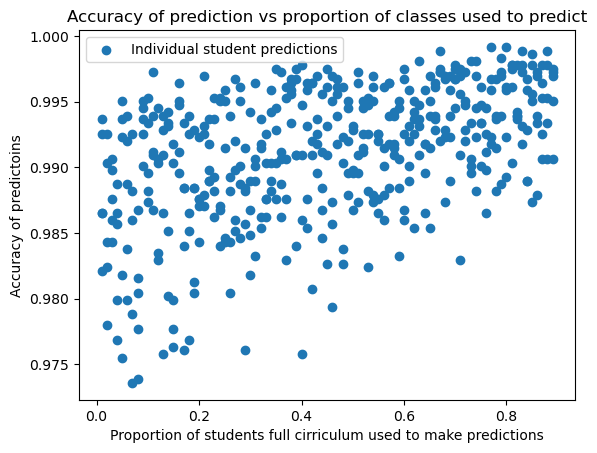

In [32]:
props, accuracies = [], []
for propCourses in range(1,90):
    input_courses, output_courses, reccomendations = user_reccomender.calculateMultipleReccomendations(user_reccomender.training_data.StudentId.sample(5, replace=False).unique().tolist(), float(propCourses)/100, 1)
    for student in output_courses.index:
        output_courses.loc[student, ~output_courses.loc[student].isna()] = 1
        output_courses.loc[student, output_courses.loc[student].isna()] = 0
        reccomendations.loc[student, reccomendations.loc[student].fillna(0) < 70] = 0
        reccomendations.loc[student, reccomendations.loc[student].fillna(0) > 70] = 1
        props.append(propCourses/100)
        accuracies.append(np.sum(np.array(output_courses.loc[student]) == np.array(reccomendations.loc[student])) / len(output_courses.loc[student]))

plt.scatter(x = props, y = accuracies, label="Individual student predictions")
plt.title("Accuracy of prediction vs proportion of classes used to predict")
plt.ylabel("Accuracy of predictoins")
plt.xlabel("Proportion of students full cirriculum used to make predictions")
plt.legend()
plt.show()

Woah, thats just absolutely crazy high accuracy.And we don't even normalize our data!

Also we have to remember how fast this result is. It's not even actually all that optimised either. If I wanted to I could cut down the cosine similarity comparisions to compute just similarities for the student we are looking at instead of comparing all students. Unfortunately dot product don't tend to behave how I would like between our values and the library we are using has no way of computing them along only one axis so that is a idea for a later date

### Creating a confusion matrix:

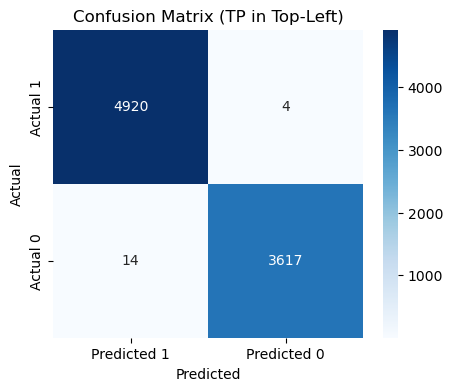

Accuracy: 0.997895967270602
Precision: 0.9971625456019457
Recall: 0.9991876523151909
F1: 0.9981740718198419


In [30]:
oneone, onezero, zeroone, zerozero = 0,0,0,0
for propCourses in range(1,90):
    input_courses, output_courses, reccomendations = user_reccomender.calculateMultipleReccomendations(user_reccomender.training_data.StudentId.sample(5, replace=False).unique().tolist(), float(propCourses)/100, 1)
    for student in output_courses.index:
        output_courses.loc[student, ~output_courses.loc[student].isna()] = 1
        output_courses.loc[student, output_courses.loc[student].isna()] = 0
        reccomendations.loc[student, reccomendations.loc[student].fillna(0) < 70] = 0
        reccomendations.loc[student, reccomendations.loc[student].fillna(0) > 70] = 1
        oneone += np.sum(np.logical_and(np.array(output_courses.loc[student]) == 1, 1 == np.array(reccomendations.loc[student])))
        onezero = np.sum(np.logical_and(np.array(output_courses.loc[student]) == 1, 0 == np.array(reccomendations.loc[student])))
        zeroone = np.sum(np.logical_and(np.array(output_courses.loc[student]) == 0, 1 == np.array(reccomendations.loc[student])))
        zerozero = np.sum(np.logical_and(np.array(output_courses.loc[student]) == 0, 0 == np.array(reccomendations.loc[student])))
cm = np.array([[oneone, onezero], [zeroone, zerozero]])
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', xticklabels=['Predicted 1', 'Predicted 0'], yticklabels=['Actual 1', 'Actual 0']) # type: ignore
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (TP in Top-Left)')
plt.show()
print("Accuracy:", (oneone + zerozero)/(oneone+ onezero + zeroone + zerozero))
print("Precision:", oneone/(oneone + zeroone))
print("Recall:", oneone/(oneone + onezero))
print("F1:", (2 * (oneone/(oneone + zeroone)) * (oneone/(oneone + onezero)))/((oneone/(oneone + zeroone))+ (oneone/(oneone + onezero))))

This makes sense! We are going to be predicting alot more false positives than false negatives because we have no idea how many classes a student will take and just reccomend all we find in similar students, so it's very unlikely we would not reccomend a class they took and more likely we picked up a random class the student didn't take

We can try to lower this number further by increasing our threshold for reccomendation

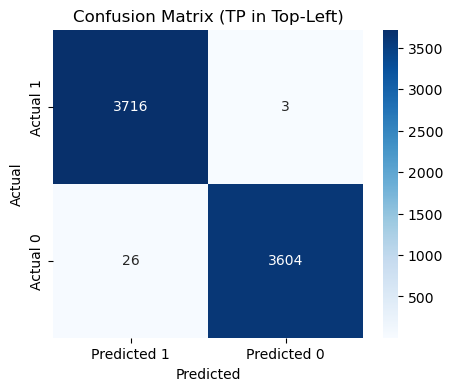

In [28]:
props, accuracies = [], []
oneone, onezero, zeroone, zerozero = 0,0,0,0
for propCourses in range(1,90):
    input_courses, output_courses, reccomendations = user_reccomender.calculateMultipleReccomendations(user_reccomender.training_data.StudentId.sample(5, replace=False).unique().tolist(), float(propCourses)/100, 1)
    for student in output_courses.index:
        output_courses.loc[student, ~output_courses.loc[student].isna()] = 1
        output_courses.loc[student, output_courses.loc[student].isna()] = 0
        reccomendations.loc[student, reccomendations.loc[student].fillna(0) < 80] = 0
        reccomendations.loc[student, reccomendations.loc[student].fillna(0) > 80] = 1
        oneone += np.sum(np.logical_and(np.array(output_courses.loc[student]) == 1, 1 == np.array(reccomendations.loc[student])))
        onezero = np.sum(np.logical_and(np.array(output_courses.loc[student]) == 1, 0 == np.array(reccomendations.loc[student])))
        zeroone = np.sum(np.logical_and(np.array(output_courses.loc[student]) == 0, 1 == np.array(reccomendations.loc[student])))
        zerozero = np.sum(np.logical_and(np.array(output_courses.loc[student]) == 0, 0 == np.array(reccomendations.loc[student])))
        props.append(propCourses/100)
        accuracies.append(np.sum(np.array(output_courses.loc[student]) == np.array(reccomendations.loc[student])) / len(output_courses.loc[student]))
cm = np.array([[oneone, onezero], [zeroone, zerozero]])
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', xticklabels=['Predicted 1', 'Predicted 0'], yticklabels=['Actual 1', 'Actual 0']) # type: ignore
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (TP in Top-Left)')
plt.show()

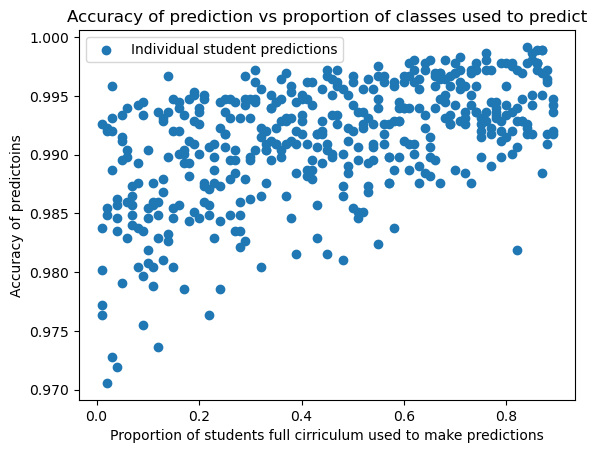

In [29]:
plt.scatter(x = props, y = accuracies, label="Individual student predictions")
plt.title("Accuracy of prediction vs proportion of classes used to predict")
plt.ylabel("Accuracy of predictoins")
plt.xlabel("Proportion of students full cirriculum used to make predictions")
plt.legend()
plt.show()

### Conclusions:
User-user based similarity is incredibly good at reccomending classes, and semi-decent at predicting scores. Cosine similarity is very standard for these models and works very well with continuious values. The biggest issue with this dataset is that there are as many classes as there are students. This means that only a handful of students could be similar to the one we are predicting for and this can lead to the (rather small) amount of error we are seeing. I am extremely happy with the results and if I were to continue work on this it would be to optmize the algorithm further